# Evaluating Bias-Variance Tradeoff

This notebook evaluates the changes in model's bias-variance as the testing-training split is varied. 

## Notebook Setup

### Import the required packages.

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from flaml.automl.ml import sklearn_metric_loss_score
from xgboost import *
import numpy as np
import matplotlib.pyplot as plt
from flaml import AutoML

### Functions

**Plotting and Model Metrics**

In [6]:
def reg_model_metrics(actual, pred):
    MSE = mean_squared_error(actual, pred) # root mean squared error
    RMSE = np.sqrt(MSE) # root mean squared error
    actual_mean = np.mean(actual) # calculate the mean for use below
    RRMSE = 100 * RMSE / actual_mean # relative root mean squared error
    R2 = r2_score(actual, pred) # coefficient of determination
    return RMSE, RRMSE, R2

def scatter_plot(y_test, y_pred_test, title):
  # Use the model metrics function to calculate RMSE, RRMSE, and R2
    RMSE, RRMSE, R2 = reg_model_metrics(y_test, y_pred_test)
  # Initialize the figure and axis
    fig,ax = plt.subplots(dpi=350)
  # Scatter the y_test vs y_pred_testicted values
    ax.scatter(y_test, y_pred_test, edgecolors=(0,0,0))
  # Plot the line of perfect fir
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
  # Make a few pieces of text that give the values of R2, RMSE, and RRMSE
    text = r"R2 = %.2f" % (R2);text += "\n"; text += r"RMSE = %.2f" % (RMSE); text += "\n"
    text += r"RRMSE = %.2f" % (RRMSE) +'%'
  # Add the text values to a plot at a particular place on the axis within a box
    plt.annotate(text, xy=(0.05, 0.85), xycoords='axes fraction',color='black', fontsize=10,
                 bbox=dict(facecolor='none',edgecolor='red'))
  # Set the x-axis label
    ax.set_xlabel('Actual Average AR IVT')
  # Set the y-axis label
    ax.set_ylabel('Predicted Average AR IVT')
  # Set the plot title
    ax.set_title(title)
  # Set the background color
    fig.patch.set_facecolor('white')
  # Show the plot
    plt.show()

In [66]:
def optimal_hyperparameter_search(X_train,y_train):


    # Initialize the automated pipeline
    automl = AutoML()


    # Set of the pipeline parameters
    settings = {
        "time_budget": 180,  # total running time in seconds, the longer the better?
        "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2']; Let's do coefficient of determination now
        "estimator_list": ['xgboost'],  # pick XGboost as from the list of ML learners in FLAML
        "task": 'regression',  # task type
        "log_file_name": 'AR_IVT_fromTCP.log',  # flaml log file
        "seed": 42,  # random seed (og)
    }

    # Fit the model iteratively using XGboost
    automl.fit(X_train=X_train, y_train=y_train, **settings)

    optimal_hyperparameters = automl.best_config

    return optimal_hyperparameters

**Bias-Variance Evaluation**

In [67]:


def run_model(x,y,train_split_percent,optimal_hyperparameters):

    """
    Splits the X & Y dataframes according to the percentage supplied,
    sets up an XGboosted regression tree using optimal hyperparameters, 
    and returns model test/train performance scores (r2).
    """

    #
    # Seperate into Test-Train splits
    X_train, X_test, y_train, y_test = train_test_split(x,y,train_size=train_split_percent,random_state=42, shuffle=True)

    #
    # Build the XGB regression model using the optimized hyperparameters
    xgb_reg = XGBRegressor(**optimal_hyperparameters)

    # Train the XGboosted regression model
    xgb_reg.fit(X_train, y_train)

    # Make some predictions
    y_pred_te = xgb_reg.predict(X_test) # On the testing split
    y_pred_tr = xgb_reg.predict(X_train) # On the training split

    #
    # Calculate some evaluation metrics on the testing set
    r2_te = r2_score(y_pred_te,y_test)
    # 
    # And calculate on the training set, too
    r2_tr = r2_score(y_pred_tr,y_train)

    # Evaluate
    print('Testing r2', '=', r2_te) 
    print('Training r2', '=', r2_tr) 



    return r2_tr, r2_te 


def bias_variance_tradeoff_params(x,y,optimal_hyperparameters,test_splits):
    
    """
    Builds lists of testing & training performance scores modulated by 
    the test-train split percentage.
    """
    
    # Set up the output lists
    test_bias = []
    train_bias = []

    # Iterate through each train-test split value
    for split in test_splits:

        X_train, X_test, y_train, y_test = train_test_split(x,y,train_size=split,random_state=42, shuffle=True)
        optimal_hyperparameters =   optimal_hyperparameter_search(X_train,y_train)

        # Setup, train, and test the XGBregression model according to the split
        r2_tr, r2_te  = run_model(x,y,split,optimal_hyperparameters)

        test_bias.append(r2_te) # Evaluation metrics for each train-test split value
        train_bias.append(r2_tr)


    
    return test_bias, train_bias

def bias_variance_plot(test_bias,train_bias,train_split_percentages):
    
    """
    Plot the coefficient of determination as modulated by the testing-training split
    """

    # Initiate the plot
    fig,ax = plt.subplots(dpi=150)

    # Plot the testing and training coefficient of determination 
    plt.plot(test_bias,label='Testing')
    plt.plot(train_bias,label='Training')

    # Make the labels from the array of splitting ratios
    labels = [str(round(pct,2)) for pct in train_split_percentages]
    plt.xticks(ticks = range(0,len(labels)),labels = labels) # Set the xtick labels with those percentages

    # Give the plot a title
    plt.title('Coefficient of Determination b/w Testing & Training Splits')
    plt.legend() # Add the legend

    plt.show()

### Data Preprocessing

**Load the dataframe and identify predictors/predictand**

In [20]:
#
# Read the atmospheric river teleconnection pattern dataframe
ar_tcp = pd.read_csv("C:/Users/kellyrm/Desktop/Research/Atmospheric River Characteristics-Teleconnection Patterns/AR_Climo_withTCP_andTrackParams.csv")

#
# Add monthly information to the dataframe
ar_tcp['month'] = pd.to_datetime(ar_tcp['datetime']).dt.month 

#
# Grab the dataframe values
y = ar_tcp['strength'] # Want to predict the AR's average IVT

x = ar_tcp[['BulkAxisDi','SSD_Theta','centroid_y', 'centroid_x', 'PMM', 'QBO', 'MEI', 'Phase','Curvature', 'Displacement','origin_lat', 'origin_lon',
       'Amplitude', 'pna_index_cdas', 'nao_index_cdas','month']] # Using physical characteristics contextualized within a synoptic environment using teleconnection pattern indices


**Initiate the testing percentage splits we'll use to evaluate the bias-variance relationship**

In [33]:
train_split_percentages = np.arange(0.5,1,0.05)

### Setting up XGboost regression tree model 

**Model hyperparameters**

In [9]:
# Results of hyperparameter tuning from FLAML in XGboost_model.ipynb
best_hyperparams = {'n_estimators': 1494, 'max_leaves': 115, 'min_child_weight': 0.28113269299604704,
                             'learning_rate': 0.091294396880665, 'subsample': 0.9077443769253482,
                             'colsample_bylevel': 0.969129617566699, 'colsample_bytree': 1.0, 'reg_alpha': 0.01044892965208733,
                               'reg_lambda': 5.262002821526985}

# Build the XGboost regression model using the hperparameters from FLAML above
xgb_reg = XGBRegressor(**best_hyperparams)

## Evaluating Bias-Variance Tradeoff

In [68]:
test_bias, train_bias = bias_variance_tradeoff_params(x,y,best_hyperparams,train_split_percentages)

[flaml.automl.logger: 08-28 12:22:44] {1679} INFO - task = regression
[flaml.automl.logger: 08-28 12:22:44] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 08-28 12:22:44] {1788} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 08-28 12:22:44] {1900} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 08-28 12:22:44] {2218} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 08-28 12:22:44] {2344} INFO - Estimated sufficient time budget=1885s. Estimated necessary time budget=2s.
[flaml.automl.logger: 08-28 12:22:44] {2391} INFO -  at 0.3s,	estimator xgboost's best error=9.9887,	best estimator xgboost's best error=9.9887
[flaml.automl.logger: 08-28 12:22:44] {2218} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 08-28 12:22:44] {2391} INFO -  at 0.4s,	estimator xgboost's best error=9.9887,	best estimator xgboost's best error=9.9887
[flaml.automl.logger: 08-28 12:22:44] {2218} INFO - iteration 2, current learner 

**Coefficient of Determination vs training %**

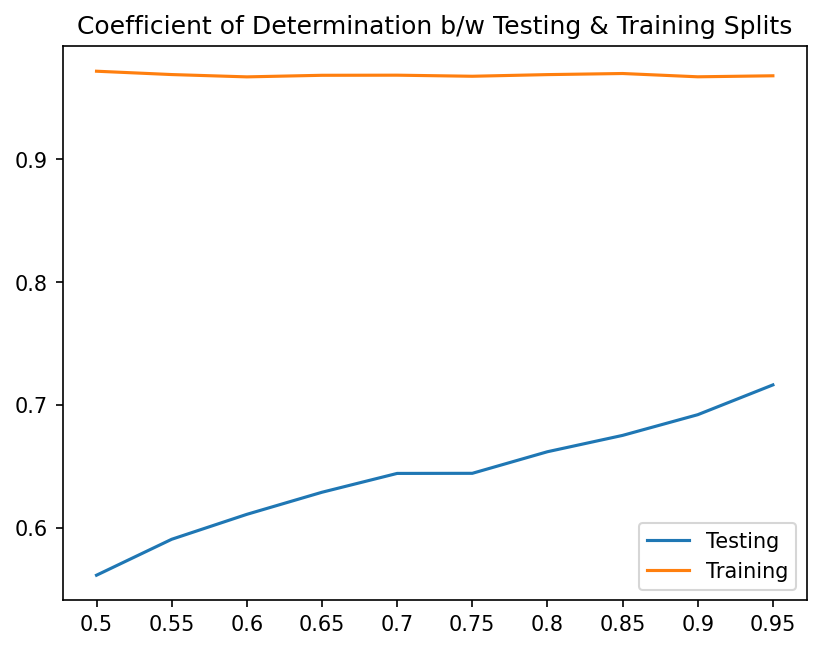

In [69]:
bias_variance_plot(test_bias,train_bias,train_split_percentages)